___
### Import data, all needed packages and display data

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

nltk.download("brown")
from nltk.corpus import brown
from collections import Counter
pd.set_option("display.max_rows", 100)
pd.set_option("display.expand_frame_repr", False)

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\moehl\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [2]:
import torch
print(torch.cuda.is_available())           # → True
print(torch.cuda.get_device_name(0))       # → NVIDIA GeForce RTX 4060 Ti

True
NVIDIA GeForce RTX 4060 Ti


In [3]:
use_cols = ["WORD", "WORD_GAZE_DURATION"]
df = pd.read_csv("Data\MonolingualReadingData.csv", usecols=use_cols)
print(df.head())

       WORD WORD_GAZE_DURATION
0       The                 95
1   intense                 54
2  interest                333
3   aroused                 78
4        in                154


___
### Create new columns that are needed for later modeling

In [4]:
# find end of sentence
df["is_sentence_end"] =  df["WORD"].str.contains(r"[.!?]$", regex=True)
df["is_sentence_end"] = df["WORD"].str.contains(r"[.!?][\"')]*$", regex=True)


# find start of sentence
df["is_sentence_start"] = df["is_sentence_end"].shift(1, fill_value=False)

# make first line the start of a sentence
df.loc[0, "is_sentence_start"] = True

# sentence id is incremented by sentence start
df["sentence_id"] = df["is_sentence_start"].cumsum()
df.loc[0, "sentence_id"] = 1

# calculate position in sentence
df["word_pos_in_sentence"] = df.groupby("sentence_id").cumcount() + 1

In [5]:
print(df[["is_sentence_start", "is_sentence_end"]].head(20))

   is_sentence_start is_sentence_end
0               True           False
1              False           False
2              False           False
3              False           False
4              False           False
5              False           False
6              False           False
7              False           False
8              False           False
9              False           False
10             False           False
11             False           False
12             False           False
13             False           False
14             False           False
15             False           False
16             False           False
17             False           False
18             False           False
19             False           False


In [6]:
print(df[["WORD", "is_sentence_end", "sentence_id", "word_pos_in_sentence"]].tail(20))

               WORD is_sentence_end sentence_id  word_pos_in_sentence
773995           is           False     80740.0                   5.0
773996          for           False     80740.0                   6.0
773997        you?"            True     80740.0                   7.0
773998     finished           False     80741.0                   1.0
773999      Poirot.            True     80741.0                   2.0
774000       "Never           False     80742.0                   1.0
774001        mind.            True     80742.0                   2.0
774002      Console           False     80743.0                   1.0
774003    yourself,           False     80743.0                   2.0
774004           my           False     80743.0                   3.0
774005      friend.            True     80743.0                   4.0
774006           We           False     80744.0                   1.0
774007          may           False     80744.0                   2.0
774008         hunt 

___
### Import text from experiment and nltk corpus for global and local frequency calculation

In [7]:
with open("Data\Corpus.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(text[:500])

CHAPTER I.
I GO TO STYLES


The intense interest aroused in the public by what was known at the
time as “The Styles Case” has now somewhat subsided. Nevertheless, in
view of the world-wide notoriety which attended it, I have been asked,
both by my friend Poirot and the family themselves, to write an account
of the whole story. This, we trust, will effectually silence the
sensational rumours which still persist.

I will therefore briefly set down the circumstances which led to my
being connected 


In [8]:
brown_tokens = [w.lower() for w in brown.words() if w.isalpha()]
text_tokens = re.findall(r"\b\w+\b", text.lower())

In [9]:
brown_counter = Counter(brown_tokens)
text_counter = Counter(text_tokens)
total_brown = sum(brown_counter.values())
total_text = sum(text_counter.values())

print(brown_counter)
print(text_counter)

Counter({'the': 69971, 'of': 36412, 'and': 28853, 'to': 26158, 'a': 23195, 'in': 21337, 'that': 10594, 'is': 10109, 'was': 9815, 'he': 9548, 'for': 9489, 'it': 8760, 'with': 7289, 'as': 7253, 'his': 6996, 'on': 6741, 'be': 6377, 'at': 5372, 'by': 5306, 'i': 5164, 'this': 5145, 'had': 5133, 'not': 4610, 'are': 4394, 'but': 4381, 'from': 4370, 'or': 4206, 'have': 3942, 'an': 3740, 'they': 3620, 'which': 3561, 'one': 3292, 'you': 3286, 'were': 3284, 'her': 3036, 'all': 3001, 'she': 2860, 'there': 2728, 'would': 2714, 'their': 2669, 'we': 2652, 'him': 2619, 'been': 2472, 'has': 2437, 'when': 2331, 'who': 2252, 'will': 2245, 'more': 2215, 'if': 2198, 'no': 2139, 'out': 2097, 'so': 1985, 'said': 1961, 'what': 1908, 'up': 1890, 'its': 1858, 'about': 1815, 'into': 1791, 'than': 1790, 'them': 1788, 'can': 1772, 'only': 1748, 'other': 1702, 'new': 1635, 'some': 1618, 'could': 1601, 'time': 1598, 'these': 1573, 'two': 1412, 'may': 1402, 'then': 1380, 'do': 1363, 'first': 1361, 'any': 1344, 'my': 

___
### Calculation of global and local frequencies

In [10]:
df["word_lower"] = df["WORD"].str.replace(r"[^a-zA-Z]", "", regex=True).str.lower()
df["global_freq_abs"] = df["word_lower"].map(brown_counter).fillna(0)
df["local_freq_abs"] = df["word_lower"].map(text_counter).fillna(0)
df["global_freq_rel"] = df["global_freq_abs"]/total_brown
df["local_freq_rel"] = df["local_freq_abs"]/total_text
df["log_global_rel"] = np.log1p(df["global_freq_rel"])
df["log_local_rel"] = np.log1p(df["local_freq_rel"])
print(df[["WORD", "word_lower", "global_freq_abs", "local_freq_abs", "global_freq_rel", "local_freq_rel", "log_global_rel", "log_local_rel"]].tail(20))

               WORD word_lower  global_freq_abs  local_freq_abs  global_freq_rel  local_freq_rel  log_global_rel  log_local_rel
773995           is         is            10109             547         0.010297        0.009405        0.010245       0.009361
773996          for        for             9489             332         0.009666        0.005708        0.009619       0.005692
773997        you?"        you             3286             944         0.003347        0.016231        0.003342       0.016101
773998     finished   finished               87               8         0.000089        0.000138        0.000089       0.000138
773999      Poirot.     poirot                2             416         0.000002        0.007153        0.000002       0.007127
774000       "Never      never              697              82         0.000710        0.001410        0.000710       0.001409
774001        mind.       mind              325              55         0.000331        0.000946        

In [11]:
df[["log_global_rel", "log_local_rel"]].corr()

,log_global_rel,log_local_rel
log_global_rel,1.00000,0.88421
log_local_rel,0.88421,1.00000


___
### Adding word length column

In [12]:
df["word_length"] = df["word_lower"].str.len()
print(df[["word_lower", "word_length", "word_pos_in_sentence", "log_global_rel", "log_local_rel", "WORD_GAZE_DURATION"]].tail(20))

       word_lower  word_length  word_pos_in_sentence  log_global_rel  log_local_rel WORD_GAZE_DURATION
773995         is          2.0                   5.0        0.010245       0.009361                393
773996        for          3.0                   6.0        0.009619       0.005692                  .
773997        you          3.0                   7.0        0.003342       0.016101                  .
773998   finished          8.0                   1.0        0.000089       0.000138                248
773999     poirot          6.0                   2.0        0.000002       0.007127                168
774000      never          5.0                   1.0        0.000710       0.001409               1141
774001       mind          4.0                   2.0        0.000331       0.000945                151
774002    console          7.0                   1.0        0.000000       0.000034                290
774003   yourself          8.0                   2.0        0.000068     

___
### Linear model using grid search (unvectorized and then vectorized for better performance)

In [13]:
df_clean = df[df["WORD_GAZE_DURATION"].apply(lambda x: str(x).isdigit())].copy()
df_clean["WORD_GAZE_DURATION"] = df_clean["WORD_GAZE_DURATION"].astype(float)
df_clean = df_clean.dropna(subset=["word_lower"]).reset_index(drop=True)

In [14]:
def predict_gaze_duration(row, weights, bias):
    return (
        weights[0] * row["word_length"]
        + weights[1] * row["word_pos_in_sentence"]
        + weights[2] * row["log_global_rel"]
        + bias
    )

def grid_search(param_range, stepsize, init_weights, bias):
    best_mse = float("inf")
    best_weights = init_weights
    mse_list = []

    steps = int(param_range / stepsize)
    offset = param_range / 2

    for i in range(steps):
        alpha = init_weights[0] - offset + i * stepsize
        for j in range(steps):
            beta = init_weights[1] - offset + j * stepsize
            for k in range(steps):
                gamma = init_weights[2] - offset + k * stepsize
                weights = [alpha, beta, gamma]
                
                df_clean["prediction"] = df_clean.apply(
                    lambda row: predict_gaze_duration(row, weights, bias), axis=1
                )
                mse = np.mean((df_clean["prediction"] - df_clean["WORD_GAZE_DURATION"])**2)
                mse_list.append((mse, weights))

                if mse < best_mse:
                    best_mse = mse
                    best_weights = weights

    return best_weights, best_mse, mse_list


In [ ]:
init_weights = np.random.uniform(-10, 10, size=3).tolist()
init_bias = np.random.uniform(-10, 10)

best_weights, best_mse, _ = grid_search(2, 0.5, init_weights, init_bias)

print("Best Weights:", best_weights)
print("Best MSE:", best_mse)

> **Performance Warning**  
This pure-Python grid search loops over every row for each weight combo—extremely slow. We’ll switch to a fully vectorized approach instead.
___

In [ ]:
df_clean = df_clean.dropna(subset=["word_length", "word_pos_in_sentence", "log_global_rel", "WORD_GAZE_DURATION"]).copy()

X = df_clean[["word_length", "word_pos_in_sentence", "log_global_rel"]].values
y = df_clean["WORD_GAZE_DURATION"].values


def predict_gaze_duration(X, weights, bias):
    return X @ weights + bias

def grid_search(X, y, param_range, stepsize, init_weights, init_bias):
    best_mse = float("inf")
    best_weights = init_weights
    best_bias = init_bias
    mse_list = []

    steps = int(param_range / stepsize)
    offset = param_range / 2

    for i in range(steps):
        alpha = init_weights[0] - offset + i * stepsize
        for j in range(steps):
            beta = init_weights[1] - offset + j * stepsize
            for k in range(steps):
                gamma = init_weights[2] - offset + k * stepsize
                for b in range(steps):
                    bias = init_bias - offset + b * stepsize
                    weights = np.array([alpha, beta, gamma])

                    preds = X @ weights + bias
                    mse = np.mean((preds - y) ** 2)
                    mse_list.append((mse, weights, bias))

                    if mse < best_mse:
                        best_mse = mse
                        best_weights = weights
                        best_bias = bias

    return best_weights, best_bias, best_mse, mse_list

In [ ]:
# Settings: (param_range, stepsize)
refinements = [(20, 2), (5, 0.5), (2, 0.2)]

# Initialisation
init_weights = np.random.uniform(-10, 10, size=3).tolist()
init_bias    = np.random.uniform(-10, 10)

for pr, ss in refinements:
    best_weights, best_bias, best_mse, _ = grid_search(
        X, y,
        param_range=pr,
        stepsize=ss,
        init_weights=init_weights,
        init_bias=init_bias
    )
    print(f"Range={pr}, Step={ss} → Best MSE: {best_mse:.2f}, Weights: {best_weights}, Bias: {best_bias}")
    # for the next refinement run
    init_weights = best_weights
    init_bias    = best_bias

Range=20, Step=2 → Best MSE: 51382.57, Weights: [1.75480343 2.06052545 8.09984273], Bias: 16.815342013752613
Range=5, Step=0.5 → Best MSE: 41714.75, Weights: [ 3.75480343  4.06052545 10.09984273], Bias: 18.815342013752613
Range=2, Step=0.2 → Best MSE: 38447.96, Weights: [ 4.55480343  4.86052545 10.89984273], Bias: 19.615342013752613


> **Performance Warning**  
This is still extremely slow. We’ll switch to a fully gradient descent-based approach instead.

___
### Comparison with Gradient Descent-Based Regression Model

In [ ]:
def predict_gaze_duration(X, weights, bias):
    return X @ weights + bias

def gradient_descent(X, y, init_weights, init_bias, learning_rate=1e-6, epochs=1000):
    weights = np.array(init_weights, dtype=np.float64)
    bias = init_bias
    n = len(y)
    mse_list = []

    for epoch in range(epochs):
        preds = predict_gaze_duration(X, weights, bias)
        errors = preds - y

        # Gradienten berechnen
        gradient_w = (2/n) * (X.T @ errors)
        gradient_b = (2/n) * np.sum(errors)

        # Parameter-Update
        weights -= learning_rate * gradient_w
        bias -= learning_rate * gradient_b

        # MSE berechnen
        mse = np.mean(errors ** 2)
        mse_list.append(mse)

        # Optional: abbrechen, wenn Änderung sehr klein
        if epoch > 10 and abs(mse_list[-2] - mse_list[-1]) < 1e-5:
            break

    return weights, bias, mse_list[-1], mse_list, preds


X = df_clean[["word_length", "word_pos_in_sentence", "log_global_rel"]].values
y = df_clean["WORD_GAZE_DURATION"].values

init_weights = np.random.uniform(-10, 10, size=3).tolist()
init_bias = np.random.uniform(-10, 10)
weights, bias, best_mse, mse_list, preds = gradient_descent(X, y, init_weights, init_bias, learning_rate=0.005, epochs=3000)

print("Best Weights:", best_weights)
print("Best bias:", best_bias)
print("Best MSE:", best_mse)
print("Best RMSE (ms):", np.sqrt(best_mse), "ms")

Best Weights: [ 4.55480343  4.86052545 10.89984273]
Best bias: 19.615342013752613
Best MSE: 13874.330329533295
Best RMSE (ms): 117.78934726677662 ms


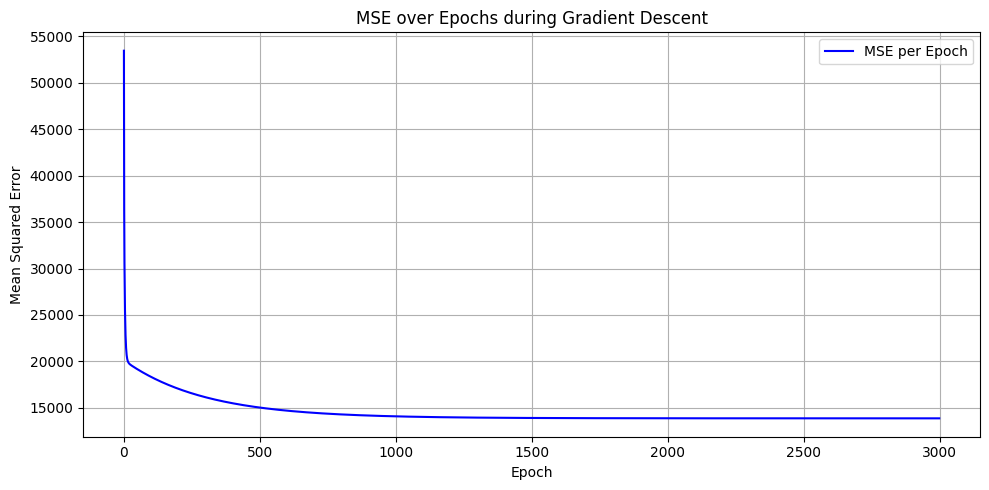

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(mse_list, label="MSE per Epoch", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("MSE over Epochs during Gradient Descent")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


comparison_df = pd.DataFrame({
    "word": df_clean["word_lower"].values,
    "gaze_duration_actual": y,
    "gaze_duration_predicted": preds
})

___
## GPT embeddings and ANN

#### The following cell fetches GPT embeddings for all unique words and saves them to a local cache file (`embeddings_dict.pkl`). On later runs, there is <span style="color:red">no need to run the following cell</span>.  


In [38]:
from openai import OpenAI
import time
import openai
import pickle
from dotenv import load_dotenv
import os

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

#Add api key
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [ ]:
from openai import OpenAI
import time
import openai
import pickle
from dotenv import load_dotenv
import os

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

#Add api key
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

#function to get embeddings
def get_embedding(word, retries=5, wait=1):
    for attempt in range(retries):
        try:
            response = client.embeddings.create(
                model="text-embedding-3-small",
                input=word
            )
            return response.data[0].embedding
        except openai.RateLimitError:
            print(f"Rate Limit erreicht bei '{word}' – Versuch {attempt + 1}, warte {wait}s...")
            time.sleep(wait)
            wait *= 2
        except Exception as e:
            print(f"Fehler bei Wort '{word}': {e}")
            return None
    print(f"Fehlgeschlagen nach {retries} Versuchen: '{word}'")
    return None


#Getting all the unique words to spare api requests
unique_words = df_clean["word_lower"].dropna().unique()

#get embeddings for every word
embedding_dict = {}

for i, word in enumerate(unique_words):
    embedding = get_embedding(word)
    if embedding:
        embedding_dict[word] = embedding
    time.sleep(0.1)


#save the dictionary as pkl file
with open("embeddings_dict.pkl", "wb") as f:
    pickle.dump(embedding_dict, f)

### Load the pkl file that contains the embeddings

In [16]:
import torch
from torch.utils.data import TensorDataset, random_split, DataLoader
import pickle
import torch.nn as nn

unique_words = df_clean["word_lower"].dropna().unique()

#Load and check data
with open("embeddings_dict.pkl", "rb") as f:
    embedding_dict = pickle.load(f)

### Prepare Embeddings, Transform Target & Create DataLoaders

In [17]:
df_clean["embedding"] = df_clean["word_lower"].map(embedding_dict)

X_embed = np.vstack(df_clean["embedding"].values)
y       = df_clean["WORD_GAZE_DURATION"].values  

df_clean["log_gaze"] = np.log1p(df_clean["WORD_GAZE_DURATION"])

y = torch.from_numpy(df_clean["log_gaze"].values).float().unsqueeze(1)
X = torch.from_numpy(X_embed).float()
ds = TensorDataset(X, y)

n_train = int(len(ds) * 0.8)
n_test  = len(ds) - n_train
train_ds, test_ds = random_split(ds, [n_train, n_test], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64)

### Define & Train Neural Network Model

In [ ]:
# Model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class GazeNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x)

model_semantic = GazeNet(input_dim=X.shape[1]).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_semantic.parameters(), lr=1e-3)

# Training loop
n_epochs = 50
for epoch in range(1, n_epochs+1):
    # Training
    model_semantic.train()
    total_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model_semantic(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)

    train_mse = total_loss / len(train_loader.dataset)

    # Validation
    model_semantic.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model_semantic(Xb)
            val_loss += criterion(preds, yb).item() * Xb.size(0)

    val_mse = val_loss / len(test_loader.dataset)

    print(f"Epoch {epoch:02d}/{n_epochs} — Train MSE: {train_mse:.4f}, Val MSE: {val_mse:.4f}")

Using device: cuda
Epoch 01/50 — Train MSE: 0.2944, Val MSE: 0.2163
Epoch 02/50 — Train MSE: 0.2215, Val MSE: 0.2124
Epoch 03/50 — Train MSE: 0.2173, Val MSE: 0.2138
Epoch 04/50 — Train MSE: 0.2147, Val MSE: 0.2107
Epoch 05/50 — Train MSE: 0.2134, Val MSE: 0.2165
Epoch 06/50 — Train MSE: 0.2124, Val MSE: 0.2099
Epoch 07/50 — Train MSE: 0.2115, Val MSE: 0.2101
Epoch 08/50 — Train MSE: 0.2107, Val MSE: 0.2094
Epoch 09/50 — Train MSE: 0.2103, Val MSE: 0.2099
Epoch 10/50 — Train MSE: 0.2098, Val MSE: 0.2096
Epoch 11/50 — Train MSE: 0.2095, Val MSE: 0.2106
Epoch 12/50 — Train MSE: 0.2091, Val MSE: 0.2117
Epoch 13/50 — Train MSE: 0.2086, Val MSE: 0.2126
Epoch 14/50 — Train MSE: 0.2085, Val MSE: 0.2087
Epoch 15/50 — Train MSE: 0.2082, Val MSE: 0.2077
Epoch 16/50 — Train MSE: 0.2079, Val MSE: 0.2083
Epoch 17/50 — Train MSE: 0.2079, Val MSE: 0.2125
Epoch 18/50 — Train MSE: 0.2077, Val MSE: 0.2126
Epoch 19/50 — Train MSE: 0.2075, Val MSE: 0.2082
Epoch 20/50 — Train MSE: 0.2073, Val MSE: 0.2078
E

In [ ]:
torch.save(model_semantic.state_dict(), "model_semantic_weights.pth")
print("model_semantic-weights saved")

model_semantic-weights saved


### Evaluate Model & Compute Final MSE/RMSE

In [ ]:
# Modell in Eval-Mode
model_semantic.eval()
preds_log, trues_log = [], []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        out = model_semantic(Xb)
        preds_log.append(out.cpu().numpy())
        trues_log.append(yb.cpu().numpy())

# Arrays zusammenführen
preds_log = np.vstack(preds_log).ravel()
trues_log = np.vstack(trues_log).ravel()

# Log-MSE
mse_log = np.mean((preds_log - trues_log)**2)

# Rücktransform und Original-MSE/RMSE
preds_ms = np.expm1(preds_log)
trues_ms = np.expm1(trues_log)
mse_ms  = np.mean((preds_ms - trues_ms)**2)
rmse_ms = np.sqrt(mse_ms)

print(f"Final Test MSE(log): {mse_log:.4f}")
print(f"Final Test RMSE(ms): {rmse_ms:.1f} ms")


Final Test MSE(log): 0.2073
Final Test RMSE(ms): 117.3 ms


___
### Combine Semantic & Syntactic Features

In [ ]:
df_clean["embedding"] = df_clean["word_lower"].map(embedding_dict)

X_embed = np.vstack(df_clean["embedding"].values)
X_syntax = df_clean[["word_length","word_pos_in_sentence","log_global_rel"]].values
X_comb = np.hstack([X_embed, X_syntax])

df_clean["log_gaze"] = np.log1p(df_clean["WORD_GAZE_DURATION"])

y = torch.from_numpy(df_clean["log_gaze"].values).float().unsqueeze(1)
X = torch.from_numpy(X_comb).float()
ds = TensorDataset(X, y)

n_train = int(len(ds) * 0.8)
n_test  = len(ds) - n_train
train_ds, test_ds = random_split(ds, [n_train, n_test], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64)

### Define & Train Neural Network Model

In [ ]:
model_combined = GazeNet(input_dim=X.shape[1]).to(device)

# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_combined.parameters(), lr=1e-3)

# Training loop
n_epochs = 50
for epoch in range(1, n_epochs+1):
    # Training
    model_combined.train()
    total_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model_combined(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)

    train_mse = total_loss / len(train_loader.dataset)

    # Validation
    model_combined.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            preds = model_combined(Xb)
            val_loss += criterion(preds, yb).item() * Xb.size(0)

    val_mse = val_loss / len(test_loader.dataset)

    print(f"Epoch {epoch:02d}/{n_epochs} — Train MSE: {train_mse:.4f}, Val MSE: {val_mse:.4f}")

Epoch 01/50 — Train MSE: 0.2826, Val MSE: 0.2365
Epoch 02/50 — Train MSE: 0.2214, Val MSE: 0.2223
Epoch 03/50 — Train MSE: 0.2169, Val MSE: 0.2108
Epoch 04/50 — Train MSE: 0.2142, Val MSE: 0.2111
Epoch 05/50 — Train MSE: 0.2126, Val MSE: 0.2094
Epoch 06/50 — Train MSE: 0.2114, Val MSE: 0.2158
Epoch 07/50 — Train MSE: 0.2105, Val MSE: 0.2100
Epoch 08/50 — Train MSE: 0.2098, Val MSE: 0.2077
Epoch 09/50 — Train MSE: 0.2088, Val MSE: 0.2084
Epoch 10/50 — Train MSE: 0.2085, Val MSE: 0.2118
Epoch 11/50 — Train MSE: 0.2080, Val MSE: 0.2081
Epoch 12/50 — Train MSE: 0.2077, Val MSE: 0.2110
Epoch 13/50 — Train MSE: 0.2073, Val MSE: 0.2219
Epoch 14/50 — Train MSE: 0.2073, Val MSE: 0.2065
Epoch 15/50 — Train MSE: 0.2069, Val MSE: 0.2074
Epoch 16/50 — Train MSE: 0.2068, Val MSE: 0.2065
Epoch 17/50 — Train MSE: 0.2066, Val MSE: 0.2066
Epoch 18/50 — Train MSE: 0.2066, Val MSE: 0.2071
Epoch 19/50 — Train MSE: 0.2065, Val MSE: 0.2065
Epoch 20/50 — Train MSE: 0.2064, Val MSE: 0.2081
Epoch 21/50 — Train 

In [ ]:
torch.save(model_combined.state_dict(), "model_combined_weights.pth")
print("model_combined-weights saved")

model_combined-weights saved


### Evaluate Model & Compute Final MSE/RMSE

In [ ]:
# Modell in Eval-Mode
model_combined.eval()
preds_log, trues_log = [], []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        out = model_combined(Xb)
        preds_log.append(out.cpu().numpy())
        trues_log.append(yb.cpu().numpy())

# Arrays zusammenführen
preds_log = np.vstack(preds_log).ravel()
trues_log = np.vstack(trues_log).ravel()

# Log-MSE
mse_log = np.mean((preds_log - trues_log)**2)

# Rücktransform und Original-MSE/RMSE
preds_ms = np.expm1(preds_log)
trues_ms = np.expm1(trues_log)
mse_ms  = np.mean((preds_ms - trues_ms)**2)
rmse_ms = np.sqrt(mse_ms)

print(f"Final Test MSE(log): {mse_log:.4f}")
print(f"Final Test RMSE(ms): {rmse_ms:.1f} ms")


Final Test MSE(log): 0.2136
Final Test RMSE(ms): 122.2 ms


___

In [20]:

EMBED_DIM = len(next(iter(embedding_dict.values())))
def load_model(path, input_dim):
    m = GazeNet(input_dim).to(device)
    m.load_state_dict(torch.load(path, map_location=device))
    m.eval()
    return m

MODEL_SEMANTIC = load_model("model_semantic_weights.pth", EMBED_DIM)
MODEL_COMBINED = load_model("model_combined_weights.pth", EMBED_DIM + 3)

# Preprocessing Functions
def preprocess_semantic(sentence):
    X = []
    for w in sentence:
        wl = w.lower()
        X.append(embedding_dict.get(wl, np.zeros(EMBED_DIM)))
    return torch.from_numpy(np.vstack(X)).float().to(device)

def preprocess_combined(sentence):
    X_sem, X_syn = [], []
    for idx, w in enumerate(sentence):
        wl = w.lower()
        emb = embedding_dict.get(wl, np.zeros(EMBED_DIM))
        length   = len(wl)
        position = idx + 1
        log_glob = np.log1p(brown_counter[wl] / total_brown)
        X_sem.append(emb)
        X_syn.append([length, position, log_glob])
    X_sem = np.vstack(X_sem)
    X_syn = np.vstack(X_syn)
    return torch.from_numpy(np.hstack([X_sem, X_syn])).float().to(device)

# Prediction Wrappers
def predict_semantic(sentence):
    X = preprocess_semantic(sentence)
    with torch.no_grad():
        preds_log = MODEL_SEMANTIC(X).cpu().numpy().ravel()
    return np.expm1(preds_log)

def predict_combined(sentence):
    X = preprocess_combined(sentence)
    with torch.no_grad():
        preds_log = MODEL_COMBINED(X).cpu().numpy().ravel()
    return np.expm1(preds_log)

# Example Usage
sentence = ["This", "is", "an", "example", "Sentence", "."]
print("Semantic-only preds:     ", predict_semantic(sentence))
print("Semantic+Syntax preds:   ", predict_combined(sentence))

C:\Users\moehl\AppData\Local\Temp\ipykernel_15120\309360906.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(path, map_location=device))


Semantic-only preds:      [218.05008 200.96416 194.02412 189.87857 235.68015  96.78091]
Semantic+Syntax preds:    [191.79771 185.51334 181.61276 191.71452 197.20367 190.28166]


In [21]:
# Extract first sentence from your cleaned DataFrame
first_sent = df_clean[df_clean["sentence_id"] == 1].reset_index(drop=True)
words       = first_sent["WORD"].tolist()
actual_ms   = first_sent["WORD_GAZE_DURATION"].tolist()

# Get predictions (semantic+syntax)
predicted_ms_semantic = predict_semantic(words)
predicted_ms_combined = predict_combined(words)

df_compare = pd.DataFrame({
    "word":      words,
    "actual_ms": actual_ms,
    "pred_ms_semantic":   np.round(predicted_ms_semantic, 1),
    "predicted_ms_combined":   np.round(predicted_ms_combined, 1)
})

print(df_compare)


         word  actual_ms  pred_ms_semantic  predicted_ms_combined
0         The       95.0        191.600006             178.199997
1     intense       54.0        216.899994             200.399994
2    interest      333.0        216.899994             210.399994
3     aroused       78.0        215.699997             208.800003
4          in      154.0        190.399994             178.199997
5         the      165.0        191.600006             178.199997
6      public      170.0        225.300003             192.899994
7          by      267.0        201.000000             182.399994
8        what      167.0        209.899994             185.699997
9       known      247.0        201.500000             189.699997
10         at      231.0        190.500000             178.199997
11        the      304.0        191.600006             178.199997
12       time      137.0        196.100006             178.199997
13       'The      164.0         96.800003             234.199997
14     Sty

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# 1) PCA ohne Dim-Limit fitten (oder n_components=X_embed.shape[1])
pca_full = PCA().fit(X_embed)

# 2) Kumulierte Varianz berechnen
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# 3) Index finden, ab dem ≥80 %
n_80 = np.searchsorted(cum_var, 0.8) + 1
print(f"Anzahl PCs für ≥80 % Varianz: {n_80}")
print(f"Kumulierte Varianz bei PC{n_80}: {cum_var[n_80-1]:.3f}")


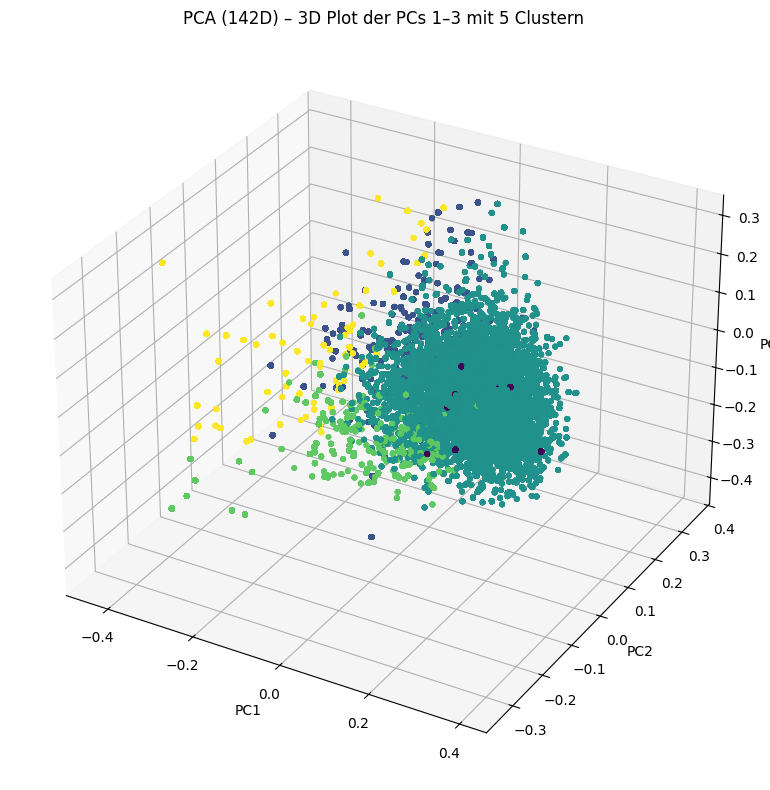

PC1: 0.0570
PC2: 0.0343
PC3: 0.0293
PC4: 0.0243
PC5: 0.0225
PC6: 0.0219
PC7: 0.0202
PC8: 0.0169
PC9: 0.0163
PC10: 0.0156
... (insgesamt 142 PCs)


In [ ]:
# 1) Embedding-Matrix holen
X_embed = np.vstack(df_clean["embedding"].values)

# 2) PCA auf 142 Komponenten (80 % Varianz)
pca = PCA(n_components=142)
X_pca = pca.fit_transform(X_embed)

# 3) KMeans-Clustering im 142-dimensionalen Raum
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X_pca)

# 4) 3D-Scatterplot der ersten drei PCs
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=labels, s=10, alpha=0.6
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA (142D) – 3D Plot der PCs 1–3 mit 5 Clustern")
plt.tight_layout()
plt.show()

# 5) Explained Variance Ratio für die ersten 10 PCs
for i, ratio in enumerate(pca.explained_variance_ratio_[:10], start=1):
    print(f"PC{i}: {ratio:.4f}")
print(f"... (insgesamt {len(pca.explained_variance_ratio_)} PCs)")


In [ ]:
for i in range(5):
    words_i = df_clean["word_lower"][labels==i]
    print(f"Cluster {i}: ", words_i.value_counts().head(10).index.tolist())

Cluster 0:  ['strychnine', 'poison', 'poisoned', 'poisoning', 'poisons', 'narcotic', 'toxicology', 'ipoison', 'arsenicnot', 'arsenic']
Cluster 1:  ['was', 'and', 'not', 'had', 'is', 'have', 'with', 'but', 'there', 'said']
Cluster 2:  ['no', 'yes', 'cavendish', 'little', 'know', 'out', 'lawrence', 'quite', 'room', 'dorcas']
Cluster 3:  ['poirot', 'he', 'her', 'she', 'inglethorp', 'his', 'me', 'mrs', 'him', 'john']
Cluster 4:  ['the', 'that', 'to', 'you', 'of', 'i', 'it', 'a', 'in', 'what']


In [ ]:
from sklearn.metrics import silhouette_score

import numpy as np
idx = np.random.choice(len(X_pca), size=10000, replace=False)
X_sample = X_pca[idx]
for k in [5,8,10,12,15,50, 100, 250, 1000]:
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_sample)
    score  = silhouette_score(X_sample, labels)
    print(f"k={k} → Silhouette: {score:.3f}")


k=5 → Silhouette: 0.055
k=8 → Silhouette: 0.072
k=10 → Silhouette: 0.090
k=12 → Silhouette: 0.104
k=15 → Silhouette: 0.120
k=50 → Silhouette: 0.266
k=100 → Silhouette: 0.380
k=250 → Silhouette: 0.536
k=1000 → Silhouette: 0.767


In [55]:
# 1) Embedding-Matrix holen
X_embed = np.vstack(df_clean["embedding"].values)

# 2) PCA auf 142 Komponenten (80 % Varianz)
pca = PCA(n_components=142)
X_pca = pca.fit_transform(X_embed)

# 3) KMeans-Clustering im 142-dimensionalen Raum
kmeans = KMeans(n_clusters=100, random_state=42)
labels = kmeans.fit_predict(X_pca)

for i in range(100):
    words_i = df_clean["word_lower"][labels==i]
    print(f"Cluster {i}: ", words_i.value_counts().head(10).index.tolist())

Cluster 0:  ['perhaps', 'possible', 'probably', 'possibly', 'possibility', 'likely', 'guess', 'hope', 'probability', 'possibilities']
Cluster 1:  ['still', 'its', 'fact', 'yet', 'ive', 'ill', 'facts', 'true', 'truth', 'id']
Cluster 2:  ['poison', 'quarrel', 'death', 'surprise', 'tragedy', 'silence', 'poisoning', 'instinct', 'destroy', 'violent']
Cluster 3:  ['to']
Cluster 4:  ['friend', 'husband', 'woman', 'dear', 'wife', 'fellow', 'our', 'kind', 'brother', 'wish']
Cluster 5:  ['think', 'thought', 'believe', 'suppose', 'understand', 'doubt', 'felt', 'prove', 'wonder', 'realize']
Cluster 6:  ['at', 'an', 'am']
Cluster 7:  ['the']
Cluster 8:  ['i', 'im', 'ii', 'j']
Cluster 9:  ['face', 'turned', 'head', 'hand', 'left', 'hands', 'handed', 'heart', 'wing', 'shoulders']
Cluster 10:  ['you', 'youyou']
Cluster 11:  ['inglethorps']
Cluster 12:  ['could', 'must', 'can', 'make', 'may', 'cant', 'cannot', 'makes']
Cluster 13:  ['coffee', 'dr', 'cocoa', 'paper', 'chemists', 'doctor', 'green', 'clea

In [56]:
df_clean["cluster"] = labels

In [60]:
# 1) Kopie anlegen
df_cluster = df_clean.copy()

# 2a) Mit Pickle speichern
df_cluster.to_pickle("df_cluster.pkl")

In [61]:
df_cluster = pd.read_pickle("df_cluster.pkl")

In [62]:
# 1) Deine Cluster-Wörter vorbereiten, z.B. dict: {cluster_id: [w1, w2, ...], ...}
df_clean_clusters = df_clean.copy()
clusters = {}
for cl in sorted(df_clean_clusters["cluster"].unique()):
    words = df_clean_clusters.loc[df_clean_clusters.cluster==cl, "word_lower"].value_counts().head(10).index.tolist()
    clusters[cl] = words

# 2) Label-Generierung
labels = {}
for cl, words in clusters.items():
    prompt = (
        "Bitte gib mir **ein einziges englisches Wort**, das am besten diese Liste von Wörtern "
        f"beschreibt: {', '.join(words)}."
    )
    resp = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "Du bist ein hilfreicher Assistent, der Cluster-Kategorien prägnant in nur einem Wort auf englisch zusammenfasst."},
            {"role": "user",   "content": prompt}
        ],
        temperature=0.0,
        max_tokens=6,
        n=1
    )
    label = resp.choices[0].message.content.strip().strip('"')
    labels[cl] = label

# 3) Labels ins DataFrame einfügen
df_clean_clusters["cluster_label"] = df_clean_clusters["cluster"].map(labels)

# 4) Kontrolle
for cl, lab in labels.items():
    print(f"Cluster {cl}: {lab}")

Cluster 0: Likelihood
Cluster 1: Veracity
Cluster 2: Darkness
Cluster 3: Preposition
Cluster 4: Family
Cluster 5: Cognition
Cluster 6: Prepositions
Cluster 7: Definite
Cluster 8: Roman numerals
Cluster 9: Bodyparts
Cluster 10: Pronouns
Cluster 11: Mystery
Cluster 12: Modalverbs
Cluster 13: Beverages
Cluster 14: Conjunctions
Cluster 15: Positive
Cluster 16: Verbs
Cluster 17: Dire.
Cluster 18: Possessive
Cluster 19: Possession
Cluster 20: Verb forms
Cluster 21: Detective
Cluster 22: Verbs
Cluster 23: Pronouns
Cluster 24: Indefinite
Cluster 25: Masculine
Cluster 26: Group
Cluster 27: Begin.
Cluster 28: Location
Cluster 29: Verbs
Cluster 30: Women
Cluster 31: Intensifiers
Cluster 32: Existence
Cluster 33: Affirmative
Cluster 34: Pronouns
Cluster 35: Exterior
Cluster 36: Pronouns
Cluster 37: Active
Cluster 38: Direction
Cluster 39: Contradictions
Cluster 40: Prepositions
Cluster 41: Observation
Cluster 42: Prepositions
Cluster 43: Temporal
Cluster 44: Storage
Cluster 45: Temporal
Cluster 46

In [63]:
# 1) Kopie anlegen
df_cluster = df_clean_clusters.copy()

# 2a) Mit Pickle speichern
df_cluster.to_pickle("df_cluster.pkl")